- Satheesh D M

- MA24M023

- Task 3 - VGG16 based edge detector

In [ ]:
# Import necessary libraries
import torch
import torch.nn as nn
import torchvision.models as models
import logging
import os
import csv
import numpy as np
import random
import torch.nn.functional as F
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt

In [ ]:
def set_seed(seed=42):
    """
    Set the seed for reproducibility in PyTorch, NumPy, and Python's random module on MPS.
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

    # For MPS (Apple Silicon)
    if torch.backends.mps.is_available():
        torch.mps.manual_seed(seed)
        print("Seed set for MPS.")
    
    torch.use_deterministic_algorithms(True, warn_only=True)
        
    print(f"Seed set to: {seed}")

# Example Usage
set_seed(42)

Seed set for MPS.
Seed set to: 42


In [ ]:
# Define the VGG16-based transposed convolutional neural network
class VGG_trans_conv(nn.Module):
    def __init__(self):
        super(VGG_trans_conv, self).__init__()

        # Encoder (VGG16)
        vgg16 = models.vgg16(weights=models.VGG16_Weights.DEFAULT)
        self.encoder = nn.Sequential(*list(vgg16.features.children())[:-1])  # (512 channels)

        # Decoder
        self.deconv1 = nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.deconv2 = nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.final_conv = nn.ConvTranspose2d(128, 1, kernel_size=1)
        self.upsample = nn.Upsample(size=(224, 224), mode='bilinear', align_corners=True)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.encoder(x)

        x = self.deconv1(x)
        x = self.relu(x)

        x = self.deconv2(x)
        x = self.relu(x)

        x = self.final_conv(x)
        x = self.upsample(x)

        return x



In [ ]:
class BalancedBCEWithLogitsLoss(nn.Module):
    def __init__(self):
        super(BalancedBCEWithLogitsLoss, self).__init__()

    def forward(self, pred, target):
        # Class balancing
        pos_count = torch.sum(target)
        neg_count = target.numel() - pos_count
        beta = neg_count / (pos_count + neg_count + 1e-6)

        weights = beta * target + (1 - beta) * (1 - target) + 1e-4
        loss = F.binary_cross_entropy_with_logits(pred, target, weight=weights)

        return loss

In [ ]:
# Configure logger
logging.basicConfig(filename='training.log', level=logging.INFO,
                    format='%(asctime)s - %(levelname)s - %(message)s')

def train_and_validate(model, train_loader, val_loader, criterion, optimizer, num_epochs=100,
                       save_path='checkpoints', model_filename='model.pth', csv_filename='losses.csv',
                       unfreeze_epoch=20):
    
    # Check and set device
    if torch.backends.mps.is_available():
        device = torch.device('mps')
        logging.info("Using MPS (Apple Metal) for acceleration.")
    elif torch.cuda.is_available():
        device = torch.device('cuda')
        logging.info("Using CUDA for acceleration.")
    else:
        device = torch.device('cpu')
        logging.info("Using CPU for training.")

    model.to(device)

    logging.info("Starting training...")
    logging.info(f"Using device: {device}")
    logging.info(f"Number of epochs: {num_epochs}")
    logging.info(f"Batch size: {train_loader.batch_size}")
    logging.info(f"Learning rate: {optimizer.param_groups[0]['lr']}")
    logging.info(f"Model architecture: {model}")
    logging.info(f"Criterion: {criterion}")
    logging.info(f"Optimizer: {optimizer}")
    logging.info(f"Training data size: {len(train_loader.dataset)}")
    logging.info(f"Validation data size: {len(val_loader.dataset)}")
    logging.info(f"Save path: {save_path}")
    logging.info(f"Unfreeze encoder after epoch: {unfreeze_epoch}")
    logging.info("Training started...")
    logging.info("Creating save directory if it doesn't exist...")
    
    os.makedirs(save_path, exist_ok=True)
    model_path = os.path.join(save_path, model_filename)
    csv_path = os.path.join(save_path, csv_filename)

    # Create CSV and write headers
    with open(csv_path, mode='w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(["Epoch", "Train Loss", "Validation Loss"])

    train_losses = []
    val_losses = []

    # Initially Freeze Encoder
    for param in model.encoder.parameters():
        param.requires_grad = False
    logging.info(f"Encoder frozen for first {unfreeze_epoch} epochs.")

    for epoch in range(num_epochs):

        # Unfreeze encoder after unfreeze_epoch
        if epoch == unfreeze_epoch:
            for param in model.encoder.parameters():
                param.requires_grad = True
            logging.info(f"Encoder unfrozen at epoch {epoch+1}.")

        # Training Phase
        model.train()
        epoch_loss = 0
        for i, (images, edges) in enumerate(train_loader):
            images, edges = images.to(device), edges.to(device)

            optimizer.zero_grad()
            outputs = model(images)

            loss = criterion(outputs, edges)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            
            logging.info(f'Iteration {i+1}/{len(train_loader)} of Epoch {epoch+1}/{num_epochs}')

        # Save model after every epoch
        torch.save(model, model_path)
        logging.info(f'Epoch {epoch+1}/{num_epochs}: Model saved to {model_path}')

        train_loss = epoch_loss / len(train_loader)
        train_losses.append(train_loss)

        # Validation Phase
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for images, edges in val_loader:
                images, edges = images.to(device), edges.to(device)

                outputs = model(images)
                loss = criterion(outputs, edges)
                val_loss += loss.item()

        val_loss /= len(val_loader)
        val_losses.append(val_loss)

        # Save to CSV
        with open(csv_path, mode='a', newline='') as f:
            writer = csv.writer(f)
            writer.writerow([epoch+1, train_loss, val_loss])

        # Log Progress
        log_msg = f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss}, Validation Loss: {val_loss}'
        logging.info(log_msg)
        print(log_msg)
    
    logging.info("Training completed.")
    
    return train_losses, val_losses



In [ ]:
class BSDS500(Dataset):
    def __init__(self, image_dir, edge_dir, transform=None, edge_transform=None):
        """
        Custom dataloader for BSDS500 edge detection dataset using JPG ground truth.

        Args:
            image_dir (str): Path to image directory (train, val, test).
            edge_dir (str): Path to corresponding edge ground truth directory.
            transform (callable, optional): Transformations for images.
            edge_transform (callable, optional): Transformations for edge maps.
        """
        self.image_dir = image_dir
        self.edge_dir = edge_dir
        self.transform = transform
        self.edge_transform = edge_transform
        self.image_files = [f for f in os.listdir(image_dir) if f.endswith('.jpg')]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        # Load Image
        img_name = self.image_files[idx]
        img_path = os.path.join(self.image_dir, img_name)
        image = Image.open(img_path).convert('RGB')

        # Load Ground Truth Edge Image
        edge_path = os.path.join(self.edge_dir, img_name)
        edge_image = Image.open(edge_path).convert('L')

        # Apply transformations
        if self.transform:
            image = self.transform(image)
        if self.edge_transform:
            edge_image = self.edge_transform(edge_image)

        return image, edge_image

# Separate transforms
vgg_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225]),
])

edge_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

g = torch.Generator()
g.manual_seed(42)

# Create Dataloaders
train_dataset = BSDS500(image_dir='archive/images/train', edge_dir='archive/ground_truth_boundaries/train',
                         transform=vgg_transform, edge_transform=edge_transform)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=0, generator=g)

val_dataset = BSDS500(image_dir='archive/images/val', edge_dir='archive/ground_truth_boundaries/val',
                       transform=vgg_transform, edge_transform=edge_transform)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=True, num_workers=0, generator=g)


In [12]:
import torch.optim as optim
# Initialize model, criterion, and optimizer
model = VGG_trans_conv()
criterion = BalancedBCEWithLogitsLoss()
lrate = 0.00001
optimizer = optim.Adam(model.parameters(), lr=lrate)

# Train and Validate
train_losses, val_losses = train_and_validate(model, train_loader, val_loader, criterion, optimizer, num_epochs=50, unfreeze_epoch=0)


Epoch [1/50], Train Loss: 0.03544363995584158, Validation Loss: 0.026887465193867685
Epoch [2/50], Train Loss: 0.025029146327422216, Validation Loss: 0.021475433818995953
Epoch [3/50], Train Loss: 0.02073250925884797, Validation Loss: 0.01883421391248703
Epoch [4/50], Train Loss: 0.018736493988679007, Validation Loss: 0.017786070182919504
Epoch [5/50], Train Loss: 0.01750325382902072, Validation Loss: 0.017247236110270025
Epoch [6/50], Train Loss: 0.01706634583668067, Validation Loss: 0.01700566664338112
Epoch [7/50], Train Loss: 0.016594336439783756, Validation Loss: 0.016795320026576518
Epoch [8/50], Train Loss: 0.016224002537245933, Validation Loss: 0.016623237766325474
Epoch [9/50], Train Loss: 0.01607729444423547, Validation Loss: 0.01659175280481577
Epoch [10/50], Train Loss: 0.015865059282917243, Validation Loss: 0.016511884108185767
Epoch [11/50], Train Loss: 0.015867909774757348, Validation Loss: 0.01646827720105648
Epoch [12/50], Train Loss: 0.0156875356601981, Validation Los

In [13]:
test_dataset = BSDS500(image_dir='archive/images/test', edge_dir='archive/ground_truth_boundaries/test',
                        transform=vgg_transform, edge_transform=edge_transform)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=True) 

In [ ]:
def plot_results(model, dataloader, threshold=0.25, device='cpu', num_batches=2):
    model.eval()
    batch_count = 0

    with torch.no_grad():
        for images, edges in dataloader:
            images = images.to(device)
            edges = edges.unsqueeze(1).to(device)

            outputs = model(images)
            probs = torch.sigmoid(outputs)  # Convert logits to probabilities
            predictions = (probs > threshold).float()

            for i in range(len(images)):
                plt.figure(figsize=(12, 4))
                
                plt.subplot(1, 3, 1)
                plt.imshow(images[i].cpu().permute(1, 2, 0))
                plt.title("Input Image")

                plt.subplot(1, 3, 2)
                plt.imshow(edges[i].cpu().squeeze(), cmap='gray')
                plt.title("Ground Truth")

                plt.subplot(1, 3, 3)
                plt.imshow(predictions[i].cpu().squeeze(), cmap='gray')
                plt.title(f"Predicted Edges (Threshold={threshold})")

                plt.show()

            batch_count += 1
            if batch_count >= num_batches:
                break

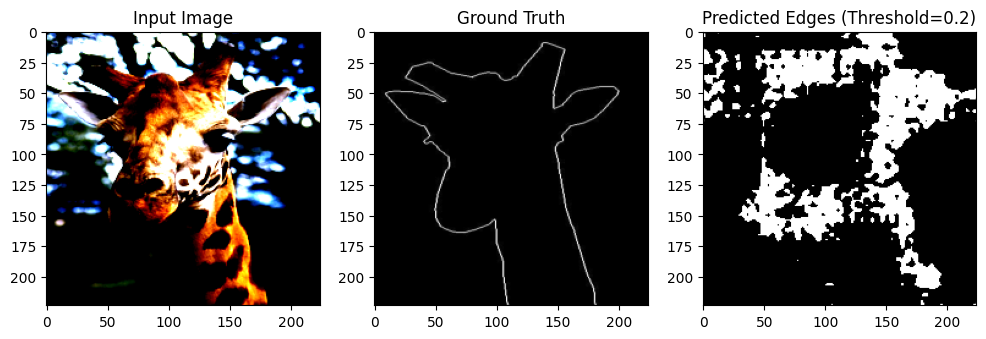

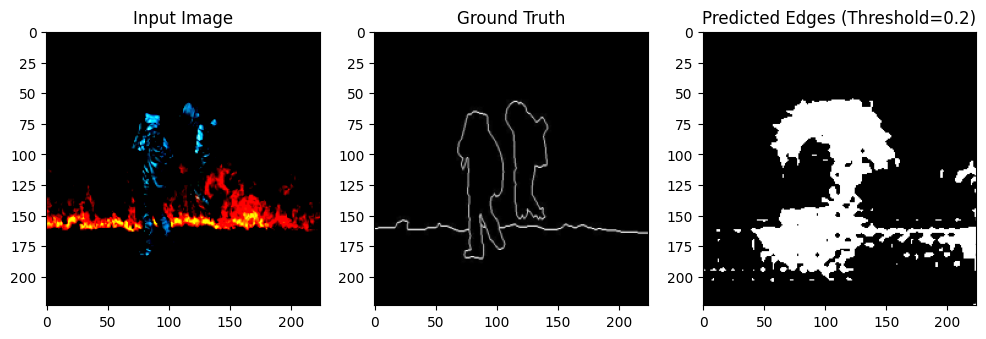

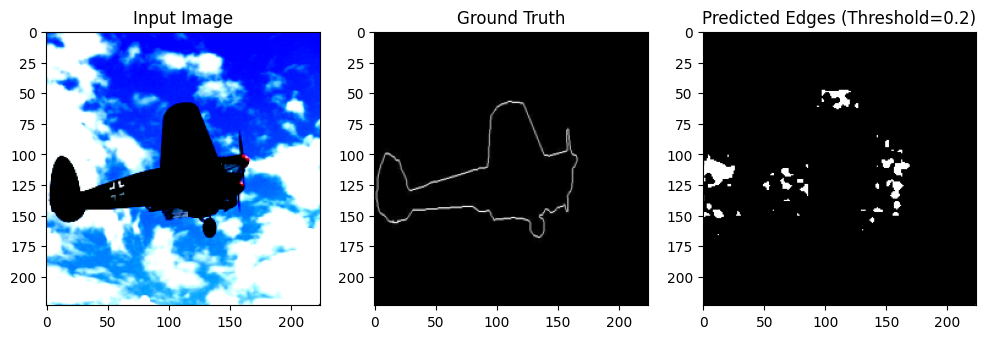

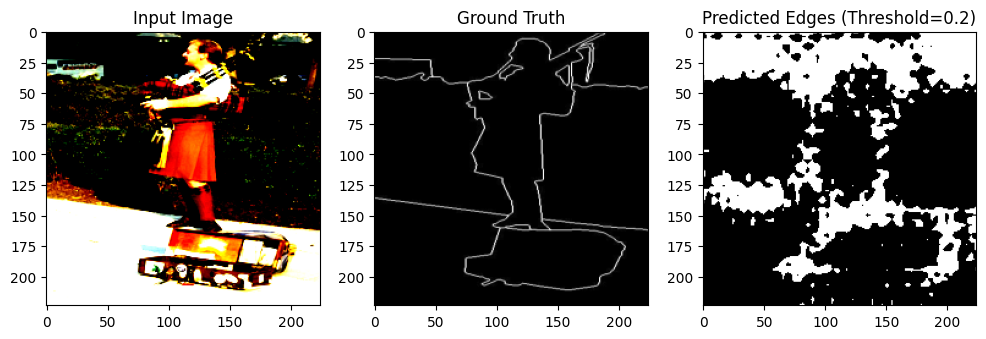

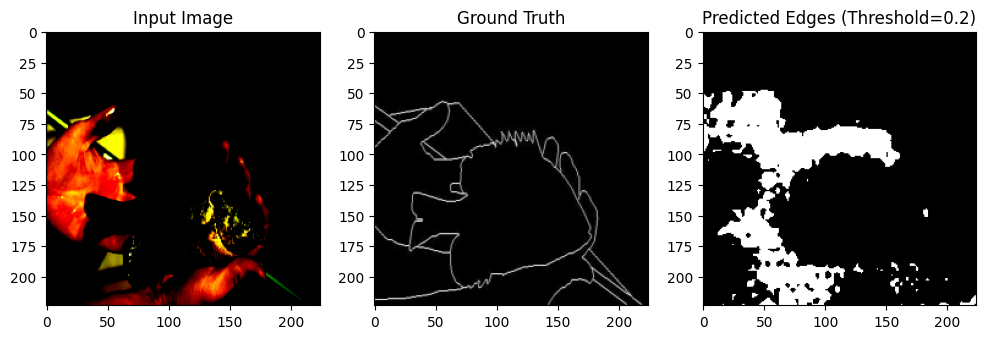

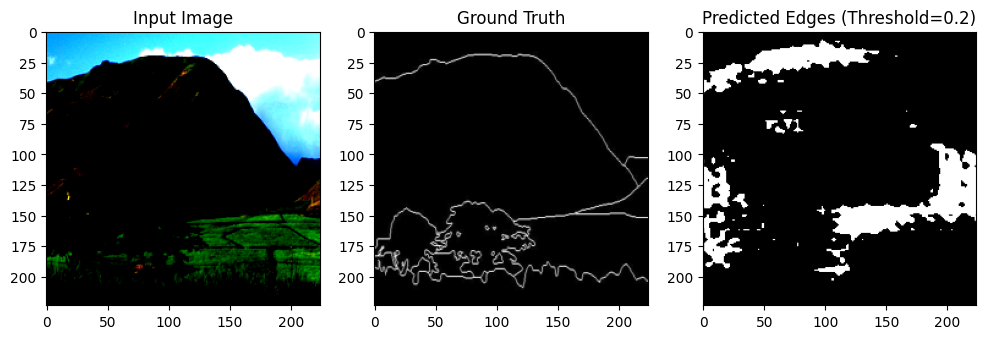

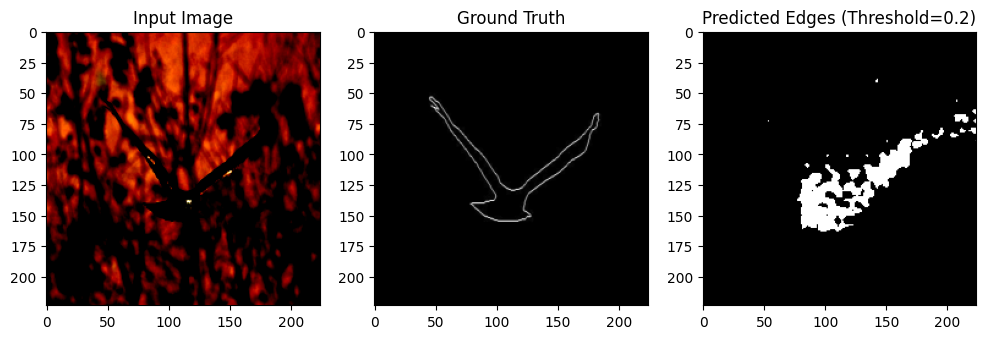

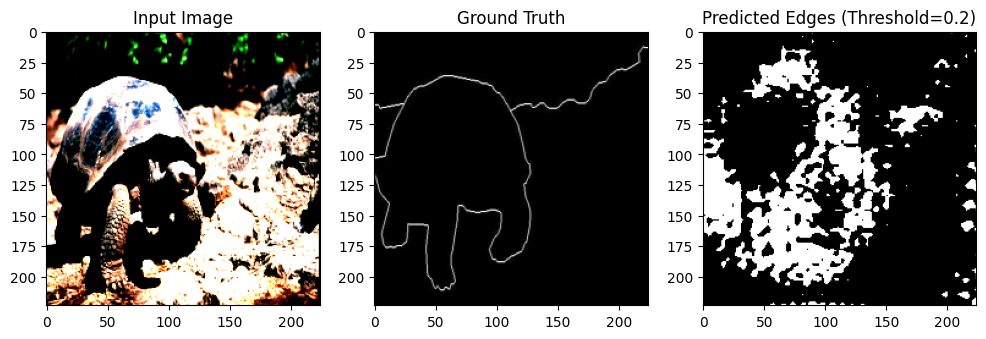

In [16]:
plot_results(model, test_loader, threshold=0.2, device='mps', num_batches=2)